In [32]:
import os
import matplotlib
import matplotlib.ticker as mtick
import seaborn as sns
from plotly import subplots
from pathlib import Path
import time as t
import requests
from requests import Request, Session
import datetime
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json
import pandas as pd

from pandas.plotting import scatter_matrix

import numpy as np
import panel as pn
from panel.interact import interact
import plotly.express as px
pn.extension("plotly")
import hvplot.pandas
from panel import widgets
import plotly.graph_objects as go

import kaleido

In [33]:
# For Website Publishing
from dotenv import load_dotenv
load_dotenv()
import chart_studio
username = os.getenv('CHART_USER')
api_key = os.getenv('CHART_KEY')

chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

import chart_studio.plotly as py
import chart_studio.tools as tls

In [34]:
# This regularly crashes the first time run but works when run a second time...

import mplfinance as mf

### ___Define a function that interacts w API and creates token dataframe;___

In [35]:
def kucoin_func(ticker):
    # Request data from api
    crypto = requests.get(f'https://api.kucoin.com/api/v1/market/candles?type=1day&symbol={ticker}-USDT&startAt=1620360000&endAt=0&limit=1000')
    
    # Import api data as json    
    crypto_j = crypto.json()
    
    # Create pandas df from json file    
    crypto_df = pd.DataFrame(crypto_j['data'])
    
    # Rename columns appropriately for later mplfinance processing
    crypto_df.rename(columns={0:'Dates',1:'Open',2:'Close',3:'High',4:'Low',6:'Volume'}, inplace=True)
    
    # Drop excess data
    crypto_df.drop(columns=5,inplace=True)
    
    # Reorder columns for mplfinance
    crypto_df = crypto_df[['Dates','Open','High','Low','Close','Volume']]
    
    # Create dataframe with converted datetime for column 'Dates'
    crypto_df_dates = pd.to_datetime(crypto_df['Dates'], unit='s')
    
    # Drop unformatted date column from primary dataframe
    crypto_df = crypto_df[['Open','High','Low','Close','Volume']]
    
    # Ensure data in OHLCV columns are floats
    crypto_df = crypto_df[['Open','High','Low','Close','Volume']].astype(float)
    
    # Concatenate 'Date' dataframe with 'OHLCV' dataframe
    crypto_frame = pd.concat([crypto_df_dates,crypto_df], axis = 1, join = 'inner')
    
    #Set index to 'Dates'
    crypto_frame.set_index('Dates',inplace=True)
    
    return crypto_frame

def binance_func(ticker):
    # Request data from api
    crypto = requests.get(f'https://api.binance.com/api/v3/klines?symbol={ticker}USDT&interval=1d&startTime=1620360000000&limit=1000')
    
    # Import api data as json    
    crypto_j = crypto.json()
    
    # Create pandas df from json file    
    crypto_df = pd.DataFrame(crypto_j)
    
    # Rename columns appropriately for later mplfinance processing
    crypto_df.rename(columns={0:'Dates',1:'Open',2:'High',3:'Low',4:'Close',7:'Volume'}, inplace=True)
    
    # Drop excess data
    crypto_df.drop(columns= [5,6,8,9,10,11], inplace=True)
    
    # Reorder columns for mplfinance
    crypto_df = crypto_df[['Dates','Open','High','Low','Close','Volume']]
    
    # Create dataframe with converted datetime for column 'Dates'
    crypto_df_dates = pd.to_datetime(crypto_df['Dates'], unit='ms')
    
    # Drop unformatted date column from primary dataframe
    crypto_df = crypto_df[['Open','High','Low','Close','Volume']]
    
    # Ensure data in OHLCV columns are floats
    crypto_df = crypto_df[['Open','High','Low','Close','Volume']].astype(float)
    
    # Concatenate 'Date' dataframe with 'OHLCV' dataframe
    crypto_frame = pd.concat([crypto_df_dates,crypto_df], axis = 1, join = 'inner')
    
    #Set index to 'Dates'
    crypto_frame.set_index('Dates',inplace=True)
    
    return crypto_frame

### ___Create list containing tickers to be used in token index___

In [36]:
index_tokens = {'kucoin_tokens':['BTC','DOT','ETH','ADA','DOGE','LTC','BNB','XRP','UNI','LINK','USDC','LUNA','AVAX','ALGO','BCH','VET','XLM'],
          'binance_tokens':['SOL','MATIC']}

mgn_tokens = {'kucoin_tokens':['DOGE', 'MANA', 'ENJ', 'SAND', 'CHZ', 'DGB'],
           'binance_tokens':['AXS', 'THETA', 'XTZ']}

fin_tokens = {'kucoin_tokens':['XRP','XLM','XDC','XTZ','LTC','BCH'],
          'binance_tokens':['HBAR']}

defi_tokens = {'kucoin_tokens':['AVAX','LINK','UNI','COMP','LUNA','ALGO'],
          'binance_tokens':['MATIC']}

### ___Create Dictionary containing portfolio weights___

In [37]:
## This 'Crypto Market Index' represents ~83% of the market and moves essentially 1:1 with market cap as a whole based on historical data. 

index_weights = {
    'BTC' : 0.42983,
    'DOT' : 0.0159,
    'ETH' : 0.193,
    'ADA' : 0.024,
    'DOGE' : 0.0121,
    'LTC' : 0.0065,
    'BNB' : 0.0378,
    'XRP' : 0.0199,
    'UNI' : 0.00661,
    'LINK' : 0.00661,
    'USDC' : 0.0262,
    'LUNA' : 0.00776,
    'AVAX' : 0.0075,
    'ALGO' : 0.0043,
    'BCH' : 0.0045,
    'VET' : 0.0038,
    'XLM' : 0.0033,
    'SOL': 0.0258,
    'MATIC': .0043}

mgn_weights = {
    'DOGE' : 0.0121,
    'MANA' : 0.00217,
    'ENJ' : 0.00091,
    'SAND' : 0.00093,
    'CHZ' : 0.0011,
    'DGB' : 0.00034,
    'AXS' : 0.0031,
    'THETA' : 0.0024,
    'XTZ' : 0.00174}


#Finance Tokens are native in their own networks
fin_weights = {
    'XRP' : 0.0199,
    'XLM' : 0.0033,
    'XDC' : 0.0004,
    'XTZ' : 0.0018,
    'LTC' : 0.0065,
    'BCH' : 0.0045,
    'HBAR': 0.0023}


#DeFi Tokens are ERC-20 (Ethereum/Binance Network)
defi_weights = {
    'AVAX' : 0.0076,
    'LINK': 0.0056,
    'UNI' : 0.0055,
    'COMP': 0.0073,
    'LUNA': 0.0085,
    'ALGO': 0.0046,
    'MATIC': 0.0043}

## ___Create 'for loop' to call function for each token that combines data into one dataframe with weighted OHLC values and summed volume___

### ___CRYPTO MARKET CAP INDEX DATA___

In [69]:
# Declare necessary empty dictionaries and lists
func = {}
w_sum = {}
index_ohlc = pd.DataFrame()
index_vol = pd.DataFrame()
index_result = None

#Index While loop 
while index_result is None:
    try:
        #Loop
        for x in index_tokens:
    
        # Run function for each token in list and add to func dictionary
            for y in index_tokens['kucoin_tokens']:
     
                func[y] = pd.DataFrame(kucoin_func(y)).iloc[::-1]
        
            for z in index_tokens['binance_tokens']:
                func[z] = pd.DataFrame(binance_func(z))
        
            for x in index_weights:
                w_sum[x] = func[x][['Open','High','Low','Close']]*index_weights[x]
    
                # Create summary dataframe for OHLC data
                index_ohlc = index_ohlc.add(w_sum[x][['Open','High','Low','Close']], fill_value = 0)
    
                # Create summary dataframe for Volume data
                index_vol = index_vol.add(func[x][['Volume']], fill_value=0)
            
        index_result = index_vol
    except:
        pass

index_ohlc_vol = [index_ohlc,index_vol]
index_frame = pd.concat(index_ohlc_vol, axis=1, join = 'inner')

### ___MEME GAMING AND NFT DATA___

In [39]:
func = {}
w_sum = {}
mgn_ohlc = pd.DataFrame()
mgn_vol = pd.DataFrame()
mgn_result = None    

while mgn_result is None:
    try:
        #Loop
        for x in mgn_tokens:
    
        # Run function for each token in list and add to func dictionary
            for y in mgn_tokens['kucoin_tokens']:
     
                func[y] = pd.DataFrame(kucoin_func(y)).iloc[::-1]
        
            for z in mgn_tokens['binance_tokens']:
                func[z] = pd.DataFrame(binance_func(z))
        
            for x in mgn_weights:
                w_sum[x] = func[x][['Open','High','Low','Close']]*mgn_weights[x]
    
                # Create summary dataframe for OHLC data
                mgn_ohlc = mgn_ohlc.add(w_sum[x][['Open','High','Low','Close']], fill_value = 0)
    
                # Create summary dataframe for Volume data
                mgn_vol = mgn_vol.add(func[x][['Volume']], fill_value=0)
            
                mgn_result = mgn_vol
    except:
        pass
    
mgn_ohlc_vol = [mgn_ohlc,mgn_vol]
mgn_frame = pd.concat(mgn_ohlc_vol, axis=1, join = 'inner')

### ___FINANCE TOKEN DATA___

In [40]:
func = {}
w_sum = {}
fin_ohlc = pd.DataFrame()
fin_vol = pd.DataFrame()
fin_result = None    

while fin_result is None:
    try:
        #Loop
        for x in fin_tokens:
    
        # Run function for each token in list and add to func dictionary
            for y in fin_tokens['kucoin_tokens']:
     
                func[y] = pd.DataFrame(kucoin_func(y)).iloc[::-1]
        
            for z in fin_tokens['binance_tokens']:
                func[z] = pd.DataFrame(binance_func(z))
        
            for x in fin_weights:
                w_sum[x] = func[x][['Open','High','Low','Close']]*fin_weights[x]
    
                # Create summary dataframe for OHLC data
                fin_ohlc = fin_ohlc.add(w_sum[x][['Open','High','Low','Close']], fill_value = 0)
    
                # Create summary dataframe for Volume data
                fin_vol = fin_vol.add(func[x][['Volume']], fill_value=0)
            
                fin_result = fin_vol
    except:
        pass
    
fin_ohlc_vol = [fin_ohlc,fin_vol]
fin_frame = pd.concat(fin_ohlc_vol, axis=1, join = 'inner')

### ___DEFI TOKEN DATA___

In [41]:
func = {}
w_sum = {}
defi_ohlc = pd.DataFrame()
defi_vol = pd.DataFrame()
defi_result = None    

while defi_result is None:
    try:
        #Loop
        for x in defi_tokens:
    
        # Run function for each token in list and add to func dictionary
            for y in defi_tokens['kucoin_tokens']:
     
                func[y] = pd.DataFrame(kucoin_func(y)).iloc[::-1]
        
            for z in defi_tokens['binance_tokens']:
                func[z] = pd.DataFrame(binance_func(z))
        
            for x in defi_weights:
                w_sum[x] = func[x][['Open','High','Low','Close']]*defi_weights[x]
    
                # Create summary dataframe for OHLC data
                defi_ohlc = defi_ohlc.add(w_sum[x][['Open','High','Low','Close']], fill_value = 0)
    
                # Create summary dataframe for Volume data
                defi_vol = defi_vol.add(func[x][['Volume']], fill_value=0)
            
                defi_result = defi_vol
    except:
        pass
    
defi_ohlc_vol = [defi_ohlc,defi_vol]
defi_frame = pd.concat(defi_ohlc_vol, axis=1, join = 'inner')

In [11]:
# Daily Returns

index_pct = index_frame.rename(columns = {'Close':'Index'})
index_chg = index_pct['Index'].pct_change().dropna()

mgn_pct = mgn_frame.rename(columns={'Close':'MGN'})
mgn_chg = mgn_pct['MGN'].pct_change().dropna()

fin_pct = fin_frame.rename(columns={'Close':'Fin'})
fin_chg = fin_pct['Fin'].pct_change().dropna()

defi_pct = defi_frame.rename(columns={'Close':'DeFi'})
defi_chg = defi_pct['DeFi'].pct_change().dropna()

combined_dr = pd.concat([index_chg, mgn_chg, fin_chg, defi_chg], axis="columns", join="inner")

In [12]:
# Covariances
mgn_cov = combined_dr['MGN'].cov(combined_dr['Index'])
fin_cov = combined_dr['Fin'].cov(combined_dr['Index'])
defi_cov = combined_dr['DeFi'].cov(combined_dr['Index'])
print(f'Meme, Gaming, NFT Cov: {mgn_cov} | Finance Token Cov: {fin_cov} | DeFi Token Cov: {defi_cov}')

Meme, Gaming, NFT Cov: 0.002542692659615856 | Finance Token Cov: 0.00224476915584819 | DeFi Token Cov: 0.002102545221467023


In [13]:
# Variance
token_var = combined_dr['Index'].var()
print(f'Token Variance: {token_var}')

Token Variance: 0.0017595722635123502


In [14]:
# Sector ETF Betas

mgn_beta = mgn_cov/token_var
fin_beta = fin_cov/token_var
defi_beta = defi_cov/token_var
print(f' MGN Beta:{mgn_beta} | Fin Beta:{fin_beta} | DeFi Beta:{defi_beta}')

 MGN Beta:1.4450629350909912 | Fin Beta:1.2757470678512057 | DeFi Beta:1.19491837025781


In [15]:
#Create Normalized Closing Price Data for plotting

index_ohlc_norm = pd.DataFrame(((index_ohlc['Close']-(index_ohlc['Close'].iloc[0]))/index_ohlc['Close'].iloc[0])*100)
index_norm = index_ohlc_norm.rename(columns={"Close":"Index %"})

mgn_ohlc_norm = pd.DataFrame(((mgn_ohlc['Close']-(mgn_ohlc['Close'].iloc[0]))/mgn_ohlc['Close'].iloc[0])*100)
mgn_norm = mgn_ohlc_norm.rename(columns={"Close":"MGN %"})

fin_ohlc_norm = pd.DataFrame(((fin_ohlc['Close']-(fin_ohlc['Close'].iloc[0]))/fin_ohlc['Close'].iloc[0])*100)
fin_norm = fin_ohlc_norm.rename(columns={"Close":"Fin %"})

defi_ohlc_norm = pd.DataFrame(((defi_ohlc['Close']-(defi_ohlc['Close'].iloc[0]))/defi_ohlc['Close'].iloc[0])*100)
defi_norm = defi_ohlc_norm.rename(columns={"Close":"DeFi %"})

all_norm_list = [index_norm, mgn_norm, fin_norm, defi_norm]
all_norm = pd.concat(all_norm_list, axis=1, join='inner')

In [16]:
# Create Normalized volume data for plotting

index_vol_norm = pd.DataFrame(((index_vol['Volume']-(index_vol['Volume'].iloc[0]))/index_vol['Volume'].iloc[0])*100)
index_vol_norm.rename(columns={"Volume":"Index Volume"}, inplace=True)

mgn_vol_norm = pd.DataFrame(((mgn_vol['Volume']-(mgn_vol['Volume'].iloc[0]))/mgn_vol['Volume'].iloc[0])*100)
mgn_vol_norm.rename(columns={"Volume":"MGN Volume"}, inplace=True)

fin_vol_norm = pd.DataFrame(((fin_vol['Volume']-(fin_vol['Volume'].iloc[0]))/fin_vol['Volume'].iloc[0])*100)
fin_vol_norm.rename(columns={"Volume":"Fin Volume"}, inplace=True)

defi_vol_norm = pd.DataFrame(((defi_vol['Volume']-(defi_vol['Volume'].iloc[0]))/defi_vol['Volume'].iloc[0])*100)
defi_vol_norm.rename(columns={"Volume":"DeFi Volume"}, inplace=True)

all_vol_list = [index_vol_norm, mgn_vol_norm, fin_vol_norm, defi_vol_norm]
all_vol = pd.concat(all_vol_list, axis=1, join='inner')

# Index Charts

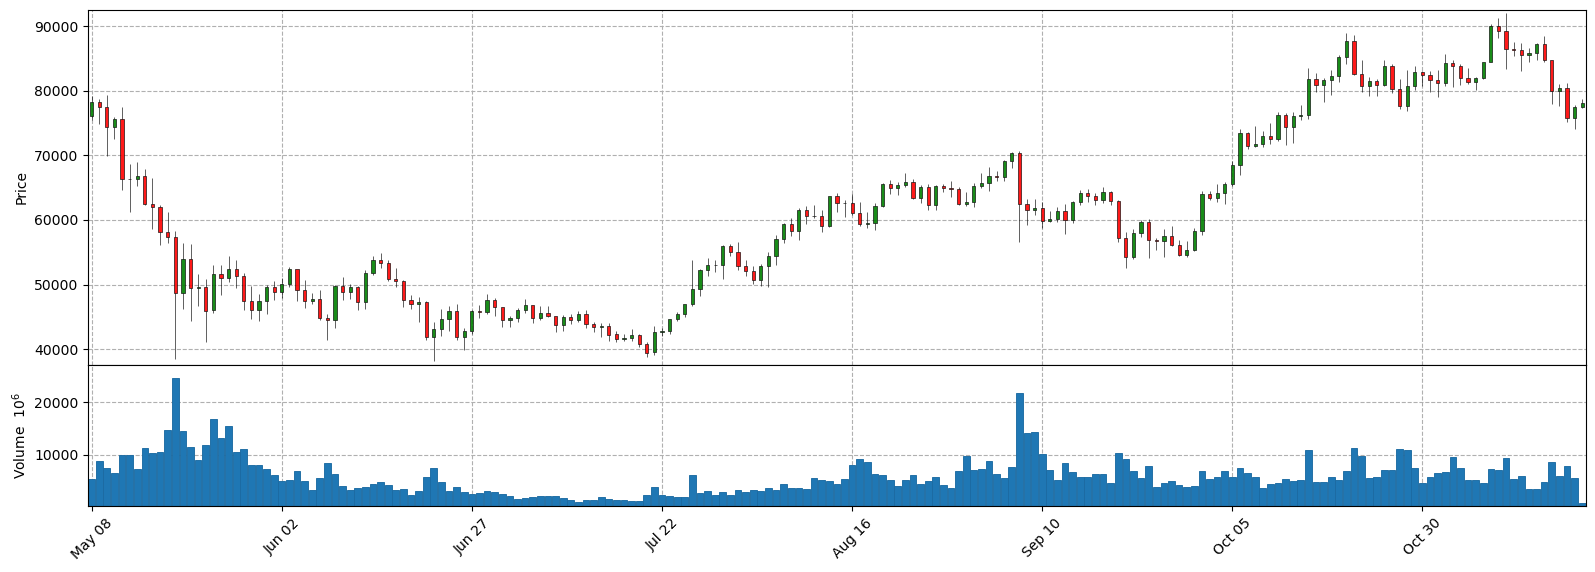

In [17]:
# Plotting Crypto Index using MPLFinance Library

mc = mf.make_marketcolors(up='g',down='r')
s  = mf.make_mpf_style(marketcolors=mc, gridstyle='dashed')
index_plot = mf.plot(index_frame, type='candle', volume=True, figratio=(30,10), style=s, tight_layout=True)

In [18]:
# Remarks about index activity (news)

### Index Token Plot for Dashboard

In [65]:
index_fig = go.Figure(data=[go.Candlestick(x=index_frame.index,
                open=index_frame['Open'],
                high=index_frame['High'],
                low=index_frame['Low'],
                close=index_frame['Close'])])

index_fig.update_layout(
     title = "Crypto Index Chart",
    yaxis_title="ETF Value",
    autosize=False,
    width=1000,
    height=700,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=2
    ),
    paper_bgcolor="LightSteelBlue",
)

index_fig.write_image("Index Chart.png")

# Meme & Gaming Charts

### Plotting MGN ETF using MPLFinance Library

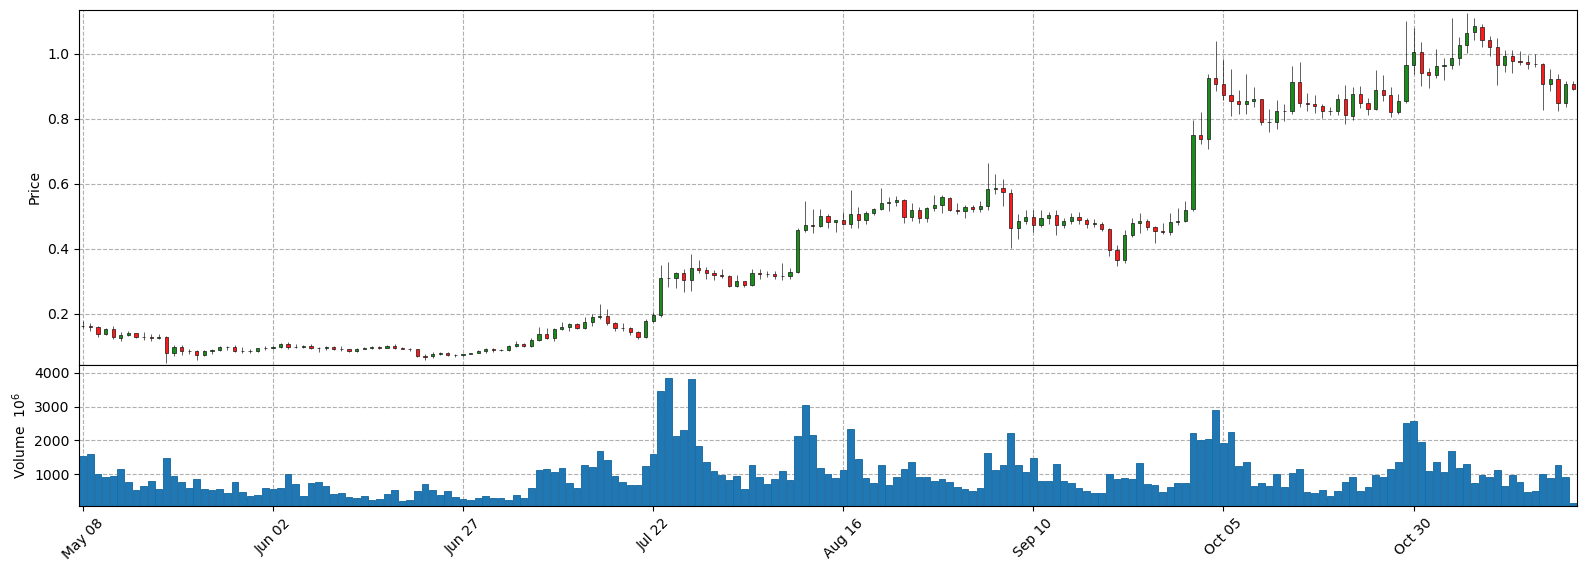

In [20]:
mc = mf.make_marketcolors(up='g',down='r')
s  = mf.make_mpf_style(marketcolors=mc, gridstyle='dashed')
mgn_plot = mf.plot(mgn_frame, type='candle', volume=True, figratio=(30,10), style=s, tight_layout=True)

In [21]:
# Remarks about sector activity (news)

### MGN Token Plot for Dashboard

In [64]:
mgn_fig = go.Figure(data=[go.Candlestick(x=mgn_frame.index,
                open=mgn_frame['Open'],
                high=mgn_frame['High'],
                low=mgn_frame['Low'],
                close=mgn_frame['Close'])])

mgn_fig.update_layout(
     title = "Meme/Gaming ETF Chart",
    yaxis_title="ETF Value",
    autosize=False,
    width=1000,
    height=700,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=2
    ),
    paper_bgcolor="LightSteelBlue",
)

mgn_fig.write_image("MGN Chart.png")

# Finance Token Charts

### Plotting Finance Token ETF using MPLFinance

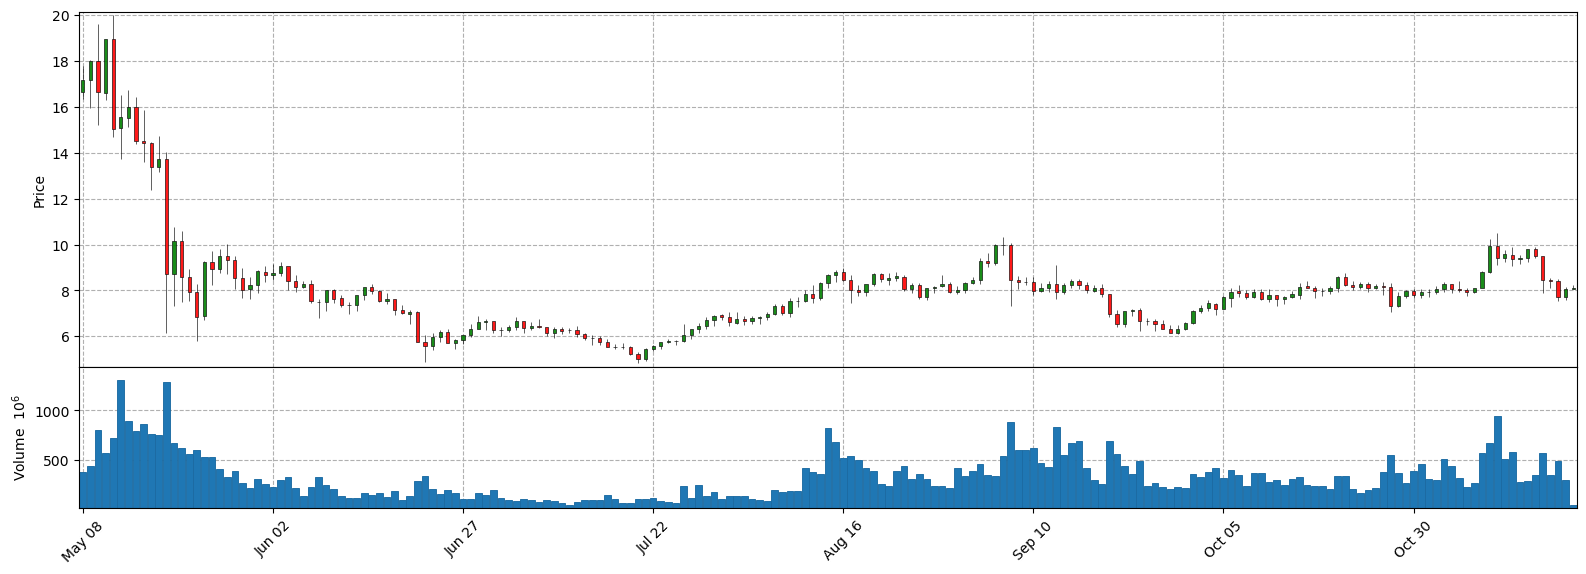

In [44]:
mc = mf.make_marketcolors(up='g',down='r')
s  = mf.make_mpf_style(marketcolors=mc, gridstyle='dashed')
fin_plot = mf.plot(fin_frame, type='candle', volume=True, figratio=(30,10), style=s, tight_layout=True)

In [45]:
# Remarks about sector (news)

### Finance Token Plot for Dashboard

In [63]:
fin_fig = go.Figure(data=[go.Candlestick(x=fin_frame.index,
                open=fin_frame['Open'],
                high=fin_frame['High'],
                low=fin_frame['Low'],
                close=fin_frame['Close'])])

fin_fig.update_layout(
     title = "Fin ETF Chart",
    yaxis_title="ETF Value",
    autosize=False,
    width=1000,
    height=700,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=2
    ),
    paper_bgcolor="LightSteelBlue",
)

fin_fig.write_image("Finance Token Chart.png")

# DeFi Tokens Charts

### Plotting DeFi Token ETF using MPLFinance Library

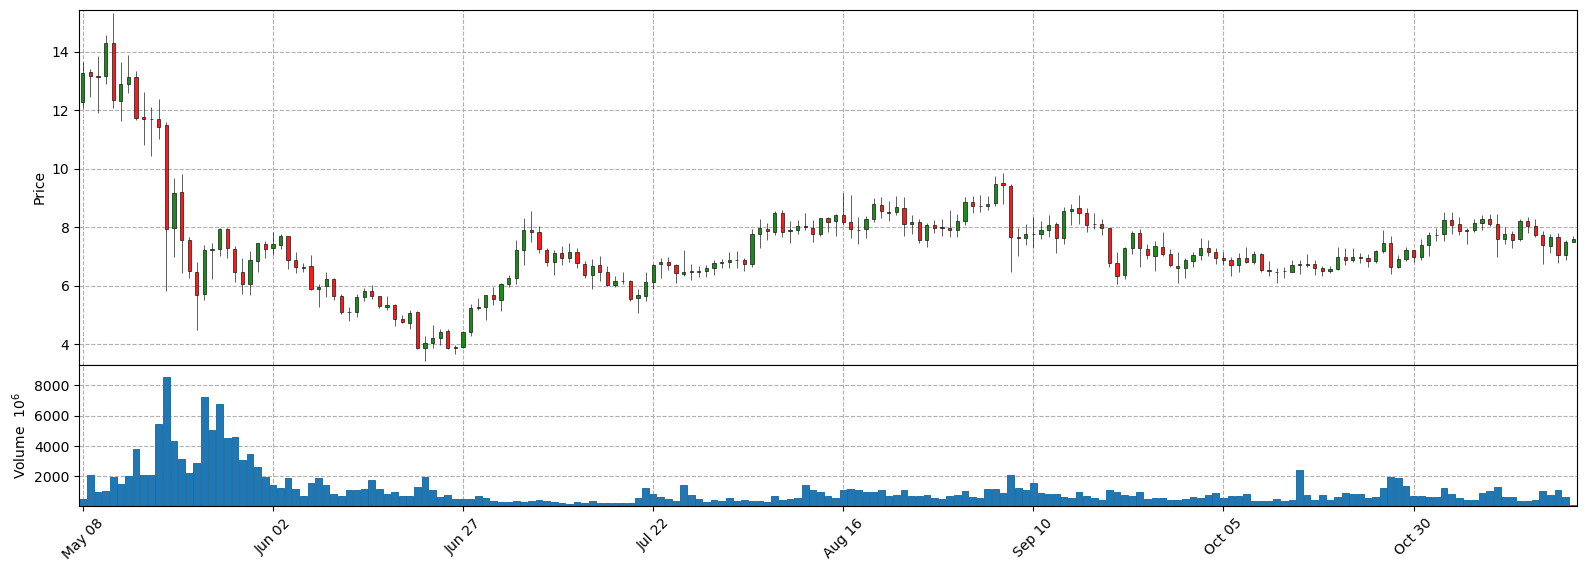

In [47]:
mc = mf.make_marketcolors(up='g',down='r')
s  = mf.make_mpf_style(marketcolors=mc, gridstyle='dashed')
defi_plot = mf.plot(defi_frame, type='candle', volume=True, figratio=(30,10), style=s, tight_layout=True)

In [48]:
# Remarks about sector (news)

### DeFi ETF Plot for Dashboard

In [62]:
defi_fig = go.Figure(data=[go.Candlestick(x=defi_frame.index,
                open=defi_frame['Open'],
                high=defi_frame['High'],
                low=defi_frame['Low'],
                close=defi_frame['Close'])])

defi_fig.update_layout(
     title = "DeFi ETF Chart",
    yaxis_title="ETF Value",
    autosize=False,
    width=1000,
    height=700,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=2
    ),
    paper_bgcolor="LightSteelBlue",
)

defi_fig.write_image("DeFi Chart.png")

### Plotting Normalized (Percentage) Returns On Same Line Graph

In [70]:
all_norm_py = px.line(all_norm)
all_norm_hv = all_norm.hvplot( rot=45, height = 500, width = 1500, title = "Normalized Returns Comparison", ylabel = "% Returns", grid=True)
all_norm_py.write_image("All Norm Plot.png")
all_norm_hv

:NdOverlay   [Variable]
   :Curve   [Dates]   (value)

### Plotting Normalized (Percentage) Volume For Comparison

In [71]:
all_vol_py = px.line(all_vol)
all_vol_py.write_image('All Vol.png')
all_vol_hv = all_vol.hvplot(kind='line', rot=45, height = 400, width = 1500, title = "All Sector Volume Plot", ylabel= "% Change in Volume from T-0", stacked = False, grid=True)
all_vol_hv

:NdOverlay   [Variable]
   :Curve   [Dates]   (value)

### Plotting Correlation Scatter Matrix

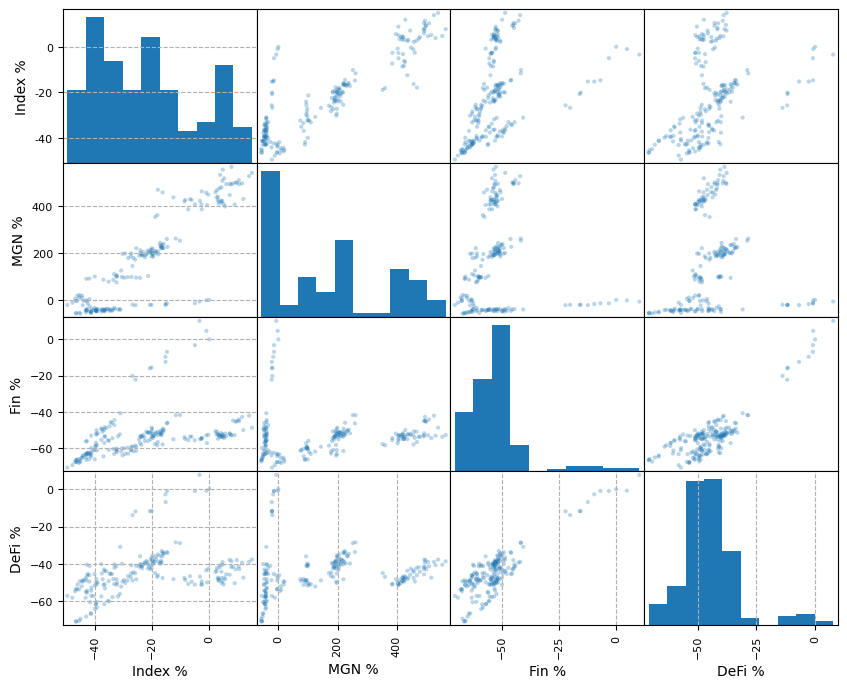

In [52]:
scat_mat = scatter_matrix(all_norm, figsize=(10,8), alpha=0.3)

### Return Correlation Heatmap for Dashboard

In [66]:
return_corr = all_norm.corr()
return_corr_plot = px.imshow(return_corr, labels = dict(color = "Ret Cor", label = 'Crypto Sector ETF Returns Correlation'))
return_corr_plot.write_image("Return Correlation.png")

### Volume Correlation Heatmap for Dashboard

In [68]:
vol_corr = all_vol.corr()
vol_corr_plot = px.imshow(vol_corr, labels = dict(color = "Vol Cor", label = 'Crypto Sector ETF Volume Correlation'))
vol_corr_plot.write_image('Volume Correlation.jpg')

## Dashboard

In [55]:
sectors0 = pn.pane.Plotly(index_fig)
sectors1 = pn.pane.Plotly(mgn_fig)
sectors2 = pn.pane.Plotly(fin_fig)
sectors3 = pn.pane.Plotly(defi_fig)

sectors = pn.Column(sectors0,sectors1, sectors2, sectors3)
returns_vol = pn.Column(all_norm_hv, all_vol_hv)
correlation = pn.Column(return_corr_plot, vol_corr_plot)
tabs = pn.Tabs(
    ('Sectors', sectors),
    ('Returns/Volume', returns_vol),
    ('Correlation Plots', correlation)
)

tabs.servable()

Tabs
    [0] Column
        [0] Plotly(Figure)
        [1] Plotly(Figure)
        [2] Plotly(Figure)
        [3] Plotly(Figure)
    [1] Column
        [0] HoloViews(NdOverlay)
        [1] HoloViews(NdOverlay)
    [2] Column
        [0] Plotly(Figure, visible=False)
        [1] Plotly(Figure, visible=False)

#### Uploading to Chart_Studio for web publishing

In [57]:
py.plot(return_corr_plot, filename="Crypto Sector Returns Correlation", auto_open=False);
py.plot(vol_corr_plot, filename = "Crypto Sector ETF Volume Correlation", auto_open=False);
py.plot(defi_fig, filename="DeFi Plot", auto_open=False);
py.plot(fin_fig, filename="Fin Plot", auto_open=False);
py.plot(index_fig, filename="Index Plot", auto_open=False);
py.plot(mgn_fig, filename="MGN Plot", auto_open=False);
py.plot(all_vol_py, filename = "All Volume", auto_open=False);
py.plot(all_norm_py, filename = "All Returns", auto_open=False);